In [1]:
# Basic
import re
import numpy as np
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Using TensorFlow backend.


In [2]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
SENTIMENT_THRESHOLDS = (0.3, 0.7)
def decode_sentiment(label):
    return decode_map[int(label)]

In [3]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = 'NEUTRAL'
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = 'NEGATIVE'
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = 'POSITIVE'

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [4]:
tokenizer = pickle.load(open("models/tokenizer.pkl", "rb" ))

In [5]:
w2v_model = gensim.models.Word2Vec.load("models/model.w2v")

2020-06-20 02:26:17,918 : INFO : loading Word2Vec object from models/model.w2v
2020-06-20 02:26:19,143 : INFO : loading wv recursively from models/model.w2v.wv.* with mmap=None
2020-06-20 02:26:19,143 : INFO : setting ignored attribute vectors_norm to None
2020-06-20 02:26:19,146 : INFO : loading vocabulary recursively from models/model.w2v.vocabulary.* with mmap=None
2020-06-20 02:26:19,149 : INFO : loading trainables recursively from models/model.w2v.trainables.* with mmap=None
2020-06-20 02:26:19,154 : INFO : setting ignored attribute cum_table to None
2020-06-20 02:26:19,155 : INFO : loaded models/model.w2v


In [6]:
W2V_SIZE = 300
SEQUENCE_LENGTH = 300

In [7]:
vocab_size = len(tokenizer.word_index) + 1

In [8]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [9]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [10]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary() 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          87125700  
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


In [11]:
from keras.models import load_model
model = load_model('models/model.h5')

In [12]:
# Text processing
# get rid of all kinds of strange symbols from text
def preprocess(Text):
    Text = Text.replace("(<br/>)", "")
    Text = Text.replace('(<a).*(>).*(</a>)', '')
    Text = Text.replace('(&amp)', '')
    Text = Text.replace('(&gt)', '')
    Text = Text.replace('(&lt)', '')
    Text = Text.replace('(\xa0…)', ' ')  
    Text = Text.replace('(\n)', ' ')
    Text = Text.replace('+', '')
    return Text

# remove urls from text
def remove_urls(row):
    url_pattern = re.compile(r"https?://\S+|www\.\S+")
    row =  url_pattern.sub(r'', row)
    return row

# remove @accounts (@[A-Za-z0–9]+)|, emojis，#hashtags, com frin text
def removes(row):
    url_pattern = re.compile(r"(\w+:\/\/\S+)|(#(\w+))|(.twitter.com/[A-Za-z0–9]+)")
    row =  url_pattern.sub(r'', row)
    return row

In [13]:
def process_text(Text):
    Text = preprocess(Text)
    Text = remove_urls(Text)
    Text = removes(Text)
    return Text

In [14]:
def predict(text, include_neutral=True):
    #start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score)}  

In [15]:
def average_sentiment(files):
    stm_dict = {}
    for file in files:
        name = file.split('.')[0]
        df = pd.read_csv(file)
        df.tweet = df.tweet.apply(process_text)
        stm = list(df.tweet.apply(lambda x:predict(x)['score']))
        avg_stm = np.mean(stm)
        #avg_stm = (stm.count('POSITIVE')-stm.count('NEGATIVE'))/len(stm)
        stm_dict[name] = avg_stm
    return stm_dict

In [16]:
def merge_data(files):
    df_list = []
    for file in files:
        name = file.split('.')[0]
        df = pd.read_csv(file)
        df.tweet = df.tweet.apply(process_text)
        df['sentiment'] = df.tweet.apply(lambda x:predict(x)['score'])
        df['company'] = name
        df_list.append(df)
    merge_df = pd.concat(df_list, axis=0)
    return merge_df

In [17]:
file=['Altice.csv', 'Charter.csv', 'RCN.csv','Sprint.csv','T-Mobile.csv', 'AT&T.csv', 'Verizon.csv']

In [18]:
sentiment = average_sentiment(file)

In [19]:
sentiment

{'Altice': 0.30472138743752086,
 'Charter': 0.5080335790983268,
 'RCN': 0.5451265310757267,
 'Sprint': 0.3432598662046458,
 'T-Mobile': 0.34394383674327716,
 'AT&T': 0.3976755080004434,
 'Verizon': 0.29018174425634224}

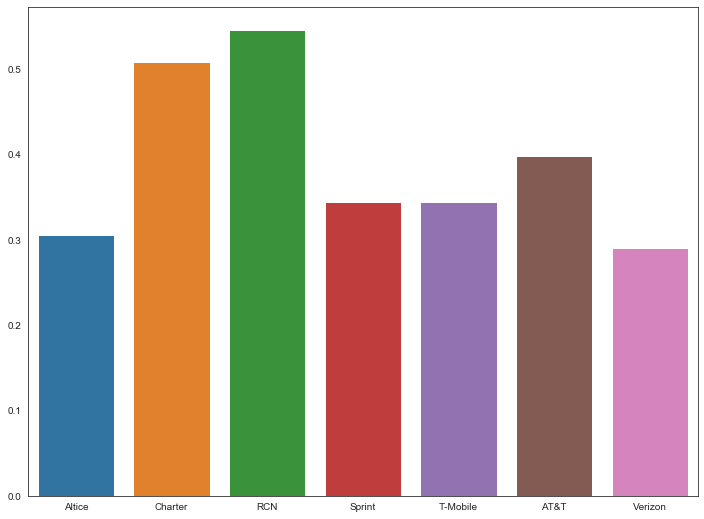

In [20]:
plt.figure(figsize=(12,9))
sns.barplot(list(sentiment.keys()), list(sentiment.values()))

In [21]:
def compute_count(files):
    count_dict = {}
    for file in files:
        name = file.split('.')[0]
        df = pd.read_csv(file)
        c = len(df)
        count_dict[name] = c
    return count_dict

In [22]:
count = compute_count(file)
count

{'Altice': 39,
 'Charter': 175,
 'RCN': 184,
 'Sprint': 912,
 'T-Mobile': 1061,
 'AT&T': 1301,
 'Verizon': 1932}

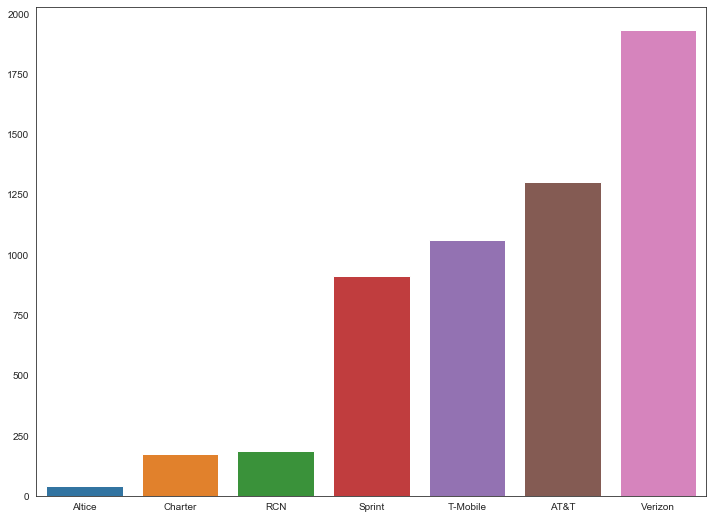

In [23]:
plt.figure(figsize=(12,9))
sns.barplot(list(count.keys()), list(count.values()))

In [24]:
df = merge_data(file)
df.head()

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


,Unnamed: 0,cashtags,company,conversation_id,created_at,date,geo,hashtags,id,likes_count,...,trans_dest,trans_src,translate,tweet,urls,user_id,user_rt,user_rt_id,username,video
0,NaN,[],Altice,1269325886031101952,1591465848000,2020-06-06,NaN,"['#georgefloyd', '#blacklivesmatter', '#icantb...",1269325886031101952,0,...,NaN,NaN,NaN,In honor of : Our Epi. 46: Justice In America...,['http://www.channelzeronyc.com'],745712790699122688,NaN,NaN,mediaoutletcom,0
1,NaN,[],Altice,1268654356179664896,1591305743000,2020-06-04,NaN,[],1268654356179664896,0,...,NaN,NaN,NaN,@OptimumHelp can you help me my spouse is at h...,[],139960955,NaN,NaN,clipboardsnacks,0
2,NaN,[],Altice,1267614761463750657,1591057884000,2020-06-01,NaN,[],1267614761463750657,0,...,NaN,NaN,NaN,@altice is the worst cable company out,[],921750007,NaN,NaN,thevinnette,0
3,NaN,[],Altice,1241801810408550400,1587000401000,2020-04-15,NaN,[],1250596444052033536,0,...,NaN,NaN,NaN,Hi I’m in the Bronx I’m an Altice one user I h...,[],196435149,NaN,NaN,musiq213,0
4,NaN,[],Altice,1248116571307982848,1586533886000,2020-04-10,NaN,[],1248639734777249799,0,...,NaN,NaN,NaN,Np. Is your WiFi under My Altice?,[],356470250,NaN,NaN,unique_naj,0


In [30]:
list(df.sort_values(by='sentiment', ascending=True)[['tweet','sentiment','company']].head(20).company)

['Sprint',
 'Verizon',
 'Verizon',
 'Verizon',
 'Verizon',
 'Verizon',
 'AT&T',
 'Verizon',
 'Verizon',
 'Verizon',
 'Verizon',
 'Verizon',
 'Verizon',
 'AT&T',
 'Verizon',
 'Verizon',
 'AT&T',
 'Verizon',
 'Sprint',
 'Verizon']

In [32]:
def get_sentiment(score):
    if score > 0.7:
        return 'Positive'
    elif score < 0.3:
        return 'Negative'
    else:
        return 'Neutral'

In [33]:
df['sentiment_text'] = df.sentiment.apply(get_sentiment)

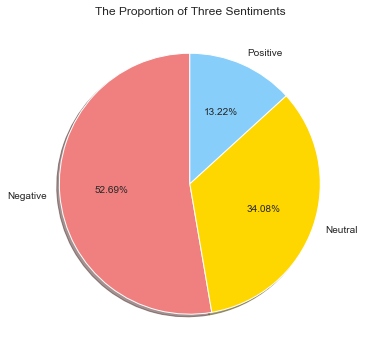

In [42]:
# draw a pie chart to show the ratio of 'Negative', 'Neutral' and 'Positive' tweets
fig = plt.figure(figsize=(6,6))
labels = 'Negative', 'Neutral', 'Positive'
sizes = df.groupby('sentiment_text').tweet.count().values
colors = ['lightcoral', 'gold', 'lightskyblue']
explode = (0.05, 0, 0) 

# Plot
plt.pie(sizes, labels=labels, colors=colors,
autopct='%1.2f%%', shadow=True, startangle=90)
plt.title('The Proportion of Three Sentiments')
plt.show()

More than half of tweets are supposed to complain about certain problematic telecom service. This indicated in most case people post a tweet since he/she met with a problem of their telecom service. 

## Time Series

In [63]:
df.date = pd.to_datetime(df.date, infer_datetime_format=True)

In [64]:
df['year'] = df.date.apply(lambda x: x.year)

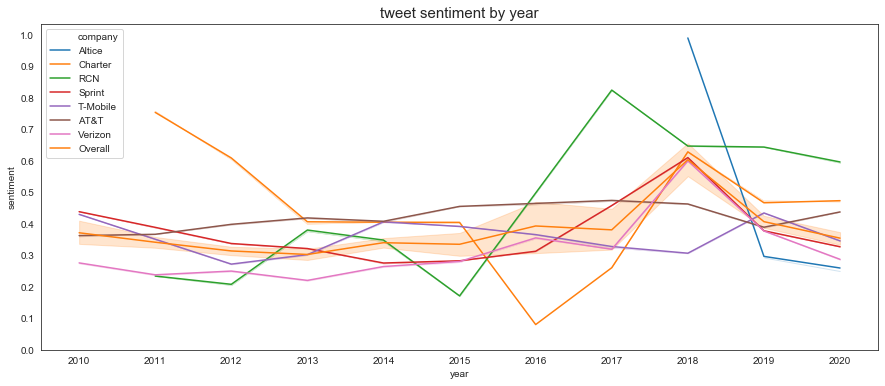

In [65]:
fig = plt.figure(figsize=(15,6))
sns.lineplot(x='year', y='sentiment', hue='company', data=df, ci=0)
sns.lineplot(x='year', y='sentiment', data=df, label='Overall')
plt.yticks(np.arange(0,1.1,0.1))
plt.xticks(np.arange(2010,2021,1))
plt.title('tweet sentiment by year', size=15)
plt.show()

The tweet sentiment gradually increased between 2013 and 2018, and then quickly decrease between 2018 and 2020. 

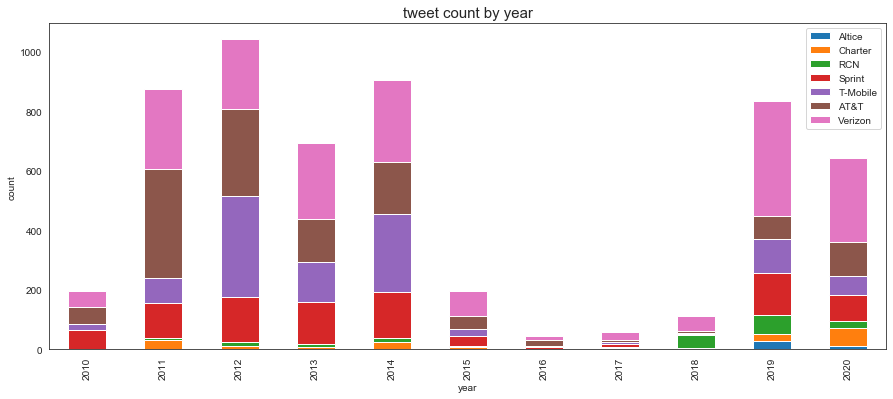

In [66]:
def aggregate(rows,columns,df):
    column_keys = df[columns].unique()
    row_keys = df[rows].unique()

    agg = { key : [ len(df[(df[rows]==value) & (df[columns]==key)]) for value in row_keys]
               for key in column_keys }

    aggdf = pd.DataFrame(agg,index = row_keys)
    aggdf.index.rename(rows,inplace=True)

    return aggdf

aggregate('year','company',df).sort_index().plot(kind='bar',stacked=True, figsize=(15,6))
plt.ylabel('count')
plt.title('tweet count by year', size=15)
plt.show()

The number of tweets between 2015 and 2018 involved with telecom are very few compared to that of other years. There are only less than 200 tweets between 2015 and 2018, while there are at least more than 600 tweets in other years.
Considering the sentiment analysis above, we can find that the low period between 2015 and 2018 corresponds to the period of increased sentiment. It means that between 2015 and 2018 people are basically more satisfied with the telecom service, posting less complaints in Twitter.

With regards to providers, Verizon, AT&T, T-mobile, Sprint account for a vast majority of the tweets. Among them, Verizon covers mobile service, cable broadband and fiber broadband while other three providers mainly focus on mobile broadband in NYC. We can conclude that in most case people tweet about their mobile provider and mobile service.

## Wordcloud

In [67]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from functools import reduce

In [68]:
sw = ['AT&T','Charter','Altice','RCN','Sprint','Verizon','T-Mobile','AT','WWW','https','com','http','instagram',
     'utm_source','ig_twitter_share','igshid','Twitter','verizon','att']
for w in sw:
    STOPWORDS.add(w)

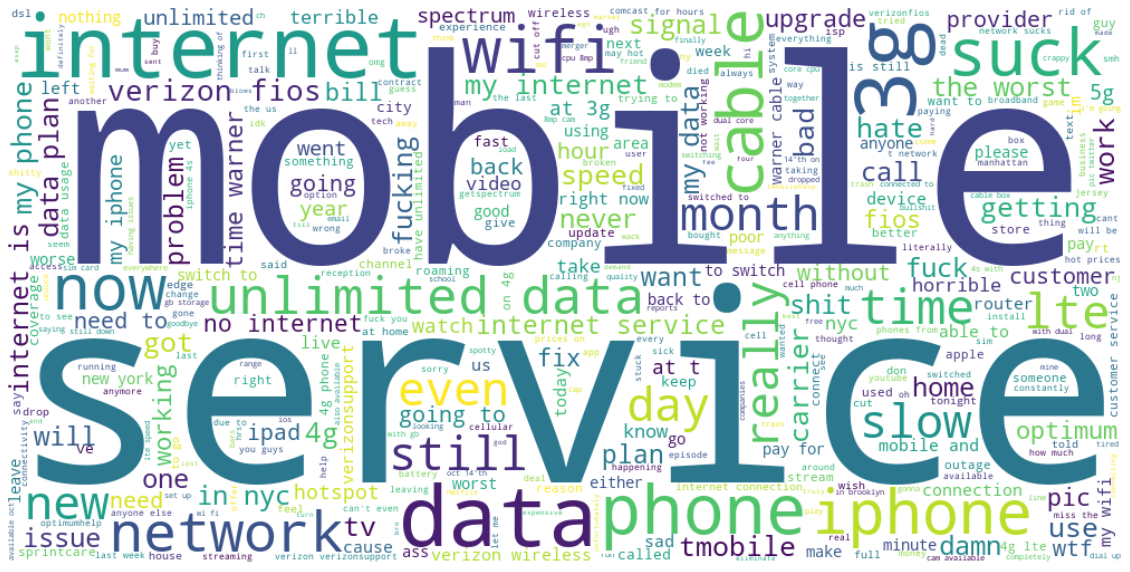

In [69]:
wc = WordCloud(background_color='white', 
               max_words=400,
               width=1000,
               height=500,
               stopwords=STOPWORDS).generate(reduce(lambda x, y: x.lower()+' '+y.lower(), list(df[df.sentiment<0.1].tweet), ''))
plt.figure(figsize=(20,20))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Considering the tweets which displays extremely negative sentiment, I draw a word cloud to show what words are commonly used in this tweets. As guessed above, mobile service are most commonly mentioned in this kind of tweets. Other significant key words like internet, data, wifi, cable, network, speed, 3g, signal, LTE, slow show that people most people complaint about the performance aspect(connectivity, accessibility, speed).
In a oligopoly market, monopoly company does not have enough incentive to maintain high service quality. This result also show that related government agency and public policy should not only focus on the quantity of providers in NYC but also pay attention to the service quality of providers. A effective policy to make provider maintain a high-quality service could also lead to social good. 

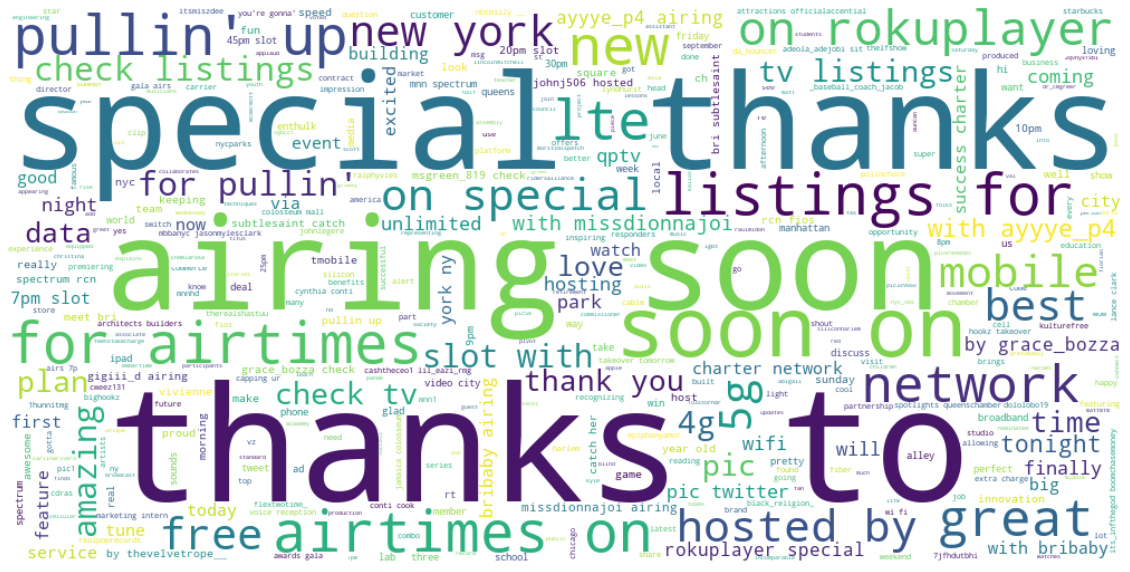

In [70]:
wc = WordCloud(background_color='white', 
               max_words=400,
               width=1000,
               height=500,
               stopwords=STOPWORDS).generate(reduce(lambda x, y: x.lower()+' '+y.lower(), list(df[df.sentiment>0.9].tweet), ''))
plt.figure(figsize=(20,20))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()